<a href="https://colab.research.google.com/github/eubielaraujo/Confusion_Matrix/blob/main/Confusion_Matrix.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from tensorflow.keras import datasets, layers, models
import matplotlib.pyplot as plt
import tensorflow as tf
import pandas as pd
import numpy as np
import seaborn as sns

In [ ]:
(train_images, train_labels), (test_images, test_labels) = datasets.cifar10.load_data()

# normalizar
train_images, test_images = train_images / 255.0, test_images / 255.0

# escolher classes (cat=3, dog=5)
wished_class = [3, 5]

# filtrar treino
mask_train = np.isin(train_labels, wished_class).flatten()
X_train = train_images[mask_train]
y_train = train_labels[mask_train]

# filtrar teste
mask_test = np.isin(test_labels, wished_class).flatten()
X_test = test_images[mask_test]
y_test = test_labels[mask_test]

# reatribuir rótulos (cat=0, dog=1)
y_train = (y_train == 5).astype(int)
y_test = (y_test == 5).astype(int)

170498071/170498071 ━━━━━━━━━━━━━━━━━━━━ 4s 0us/step


In [25]:
model = models.Sequential()
model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(32, 32, 3)))
model.add(layers.MaxPooling2D((2,2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2,2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))

model.add(layers.Flatten())
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))  # saída binária

In [ ]:
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

model.fit(X_train,
          y_train,
          epochs=5,
          validation_data=(X_test, y_test))

Epoch 1/5
313/313 ━━━━━━━━━━━━━━━━━━━━ 10s 27ms/step - accuracy: 0.5448 - loss: 0.6797 - val_accuracy: 0.6470 - val_loss: 0.6362
Epoch 2/5
313/313 ━━━━━━━━━━━━━━━━━━━━ 10s 25ms/step - accuracy: 0.6353 - loss: 0.6287 - val_accuracy: 0.6865 - val_loss: 0.5850
Epoch 3/5
313/313 ━━━━━━━━━━━━━━━━━━━━ 9s 27ms/step - accuracy: 0.6860 - loss: 0.5827 - val_accuracy: 0.6850 - val_loss: 0.5856
Epoch 4/5
313/313 ━━━━━━━━━━━━━━━━━━━━ 9s 27ms/step - accuracy: 0.7347 - loss: 0.5302 - val_accuracy: 0.7120 - val_loss: 0.5492
Epoch 5/5
313/313 ━━━━━━━━━━━━━━━━━━━━ 9s 29ms/step - accuracy: 0.7516 - loss: 0.4970 - val_accuracy: 0.7440 - val_loss: 0.5081


In [ ]:
y_true = y_test.flatten()  # rótulos reais 0 ou 1
y_pred = (model.predict(X_test) > 0.5).astype("int32").flatten()  # previsões 0 ou 1

cm = tf.math.confusion_matrix(labels=y_true, predictions=y_pred).numpy()

cm_norm = cm.astype("float") / cm.sum(axis=1)[:, np.newaxis]

63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step


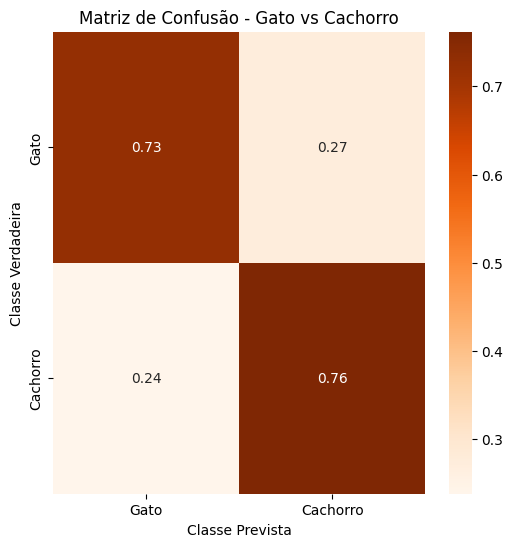

In [19]:
# Visualizar a matriz de confusão
plt.figure(figsize=(6, 6))
sns.heatmap(cm_norm, annot=True, cmap='Oranges',
              xticklabels=['Gato', 'Cachorro'],
              yticklabels=['Gato', 'Cachorro'])
plt.xlabel('Classe Prevista')
plt.ylabel('Classe Verdadeira')
plt.title('Matriz de Confusão - Gato vs Cachorro')
plt.show()

In [20]:
sens = cm[1,1] / (cm[1,1] + cm[1,0])
esp = cm[0,0] / (cm[0,0] + cm[0,1])
acc = (cm[0,0] + cm[1,1]) / cm.sum()
prec = cm[1,1] / (cm[1,1] + cm[0,1])
f1 = 2 * (prec * sens) / (prec + sens)

print(f"Sensibilidade: {sens} \nEspecificidade: {esp} \nAcurácia: {acc} \nPrecisão: {prec} \nF-score: {f1}")



Sensibilidade: 0.762 
Especificidade: 0.726 
Acurácia: 0.744 
Precisão: 0.7355212355212355 
F-score: 0.7485265225933202


63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step


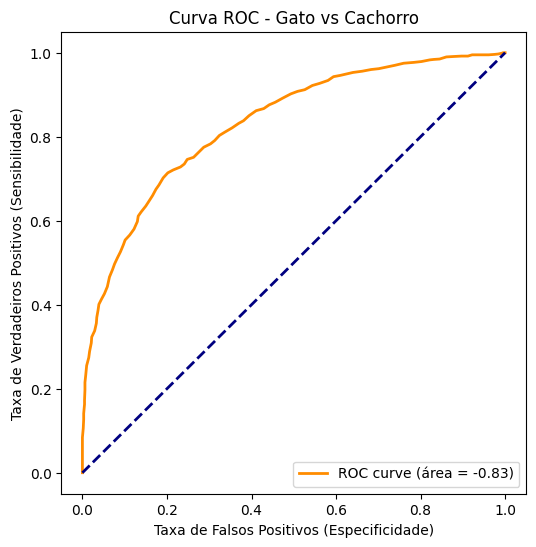

In [21]:
# Probabilidades previstas (saída do modelo sigmoid)
y_prob = model.predict(X_test).ravel()
y_true = y_test.ravel()

# Definir thresholds de 0 a 1
thresholds = np.linspace(0, 1, 101)
tpr_list = []
fpr_list = []

for t in thresholds:
    y_pred = (y_prob >= t).astype(int)

    TP = np.sum((y_pred == 1) & (y_true == 1))
    TN = np.sum((y_pred == 0) & (y_true == 0))
    FP = np.sum((y_pred == 1) & (y_true == 0))
    FN = np.sum((y_pred == 0) & (y_true == 1))

    # Taxa de verdadeiros positivos (sensibilidade)
    TPR = TP / (TP + FN) if (TP + FN) > 0 else 0
    # Taxa de falsos positivos
    FPR = FP / (FP + TN) if (FP + TN) > 0 else 0

    tpr_list.append(TPR)
    fpr_list.append(FPR)

# Calcular AUC via regra do trapézio (integração numérica)
auc = np.trapezoid(tpr_list, fpr_list)

# Plotar curva ROC
plt.figure(figsize=(6,6))
plt.plot(fpr_list, tpr_list, color="darkorange", lw=2,
         label=f"ROC curve (área = {auc:.2f})")
plt.plot([0, 1], [0, 1], color="navy", lw=2, linestyle="--")
plt.xlabel("Taxa de Falsos Positivos (Especificidade)")
plt.ylabel("Taxa de Verdadeiros Positivos (Sensibilidade)")
plt.title("Curva ROC - Gato vs Cachorro")
plt.legend(loc="lower right")
plt.show()